In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/water_dataX.csv"

In [ ]:
!pip install xgboost tensorflow scikit-learn --quiet

# ================================================
# Step 1: Import Libraries
# ================================================
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from tensorflow.keras import models, layers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [ ]:
# Try multiple encodings to avoid UnicodeDecodeError
encodings = ["utf-8", "latin1", "cp1252", "iso-8859-1"]
for enc in encodings:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        print(f"✅ Loaded successfully with encoding: {enc}")
        break
    except:
        continue

print("Columns in dataset:", df.columns.tolist())

✅ Loaded successfully with encoding: latin1
Columns in dataset: ['STATION CODE', 'LOCATIONS', 'STATE', 'Temp', 'D.O. (mg/l)', 'PH', 'CONDUCTIVITY (µmhos/cm)', 'B.O.D. (mg/l)', 'NITRATENAN N+ NITRITENANN (mg/l)', 'FECAL COLIFORM (MPN/100ml)', 'TOTAL COLIFORM (MPN/100ml)Mean', 'year']


In [ ]:
# Step 3: Clean Column Names
# ================================================
df.columns = (df.columns.astype(str)
              .str.strip()
              .str.lower()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[\(\)/\.]", "", regex=True))


In [ ]:
# Optional: Rename known columns
rename_map = {
    'temp':'temp', 'temperature':'temp',
    'd.o._mgl':'do_mg_l', 'd.o_mgl':'do_mg_l', 'do_mgl':'do_mg_l',
    'ph':'ph',
    'b.o.d._mgl':'bod_mg_l', 'bod_mg_l':'bod_mg_l',
    'nitratenan_n+_nitritenann_mgl':'nitrate','nitrate':'nitrate',
    'fecal_coliform_mpn100ml':'fecal_coliform','fecal_coliform':'fecal_coliform',
    'total_coliform_mpn100mlmean':'total_coliform','total_coliform':'total_coliform'
}
existing_renames = {k:v for k,v in rename_map.items() if k in df.columns}
df.rename(columns=existing_renames, inplace=True)

# ================================================

In [ ]:
# ================================================
cols_numeric = ['temp','do_mg_l','ph','bod_mg_l','nitrate','fecal_coliform','total_coliform']
for c in cols_numeric:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [ ]:
# Step 5: Drop rows with essential missing values
# ================================================
essential_cols = [c for c in ['ph','do_mg_l','bod_mg_l'] if c in df.columns]
print("Essential columns present:", essential_cols)
df.dropna(subset=essential_cols, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Cleaned shape:", df.shape)

Essential columns present: ['ph', 'do_mg_l']
Cleaned shape: (1960, 12)


In [ ]:
# # ================================================
# # Step 6: Compute Water Quality Index (Improved)
# # ================================================

# # Keep only important numeric columns
# features_wqi = [c for c in ['ph','do_mg_l','bod_mg_l','nitrate','fecal_coliform','total_coliform'] if c in df.columns]
# df[features_wqi] = df[features_wqi].fillna(df[features_wqi].median())

# # Define standard values (based on BIS/WHO guidelines)
# standards = {
#     'ph': 7.0,                    # ideal neutral
#     'do_mg_l': 7.0,               # mg/L (higher is better)
#     'bod_mg_l': 3.0,              # mg/L (lower is better)
#     'nitrate': 45.0,              # mg/L (WHO limit)
#     'fecal_coliform': 500.0,      # MPN/100mL (safe)
#     'total_coliform': 500.0       # MPN/100mL (safe)
# }

# # Assign feature weights (based on importance)
# weights = {
#     'ph': 0.12,
#     'do_mg_l': 0.25,
#     'bod_mg_l': 0.23,
#     'nitrate': 0.15,
#     'fecal_coliform': 0.15,
#     'total_coliform': 0.10
# }

# # Normalize and compute sub-index (Qi) for each parameter
# Qi = pd.DataFrame()

# for feature in features_wqi:
#     val = df[feature].astype(float)

#     if feature == 'ph':
#         # pH ideal 7, penalize deviation
#         Qi[feature] = (100 * abs(val - standards['ph']) / 7.0).clip(0, 100)
#     elif feature == 'do_mg_l':
#         # Higher DO -> better quality
#         Qi[feature] = (100 * (standards['do_mg_l'] - val) / standards['do_mg_l']).clip(0, 100)
#     else:
#         # Higher pollutant -> worse quality
#         Qi[feature] = (100 * val / standards[feature]).clip(0, 100)

# # Weighted WQI
# wqi_num = sum(Qi[f] * weights[f] for f in features_wqi)
# wqi_denom = sum(weights[f] for f in features_wqi)
# df['wqi_composite'] = (wqi_num / wqi_denom).round(2)

# # Classify water quality
# def classify_wqi(v):
#     if v <= 10: return 'Excellent'
#     elif v <= 30: return 'Good'
#     elif v <= 50: return 'Poor'
#     elif v <= 70: return 'Very Poor'
#     else: return 'Unsuitable'

# df['quality_class'] = df['wqi_composite'].apply(classify_wqi)

# print("\n✅ Updated WQI Computation Done.")
# print(df['quality_class'].value_counts())



In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(7,4))
# sns.countplot(data=df, x='quality_class', palette='viridis')
# plt.title("Water Quality Class Distribution (After Fix)")
# plt.xlabel("Quality Class")
# plt.ylabel("Count")
# plt.show()


In [ ]:
# Step 6: Compute Water Quality Index (WQI)
# ================================================
features_wqi = [c for c in ['ph','do_mg_l','bod_mg_l','nitrate','fecal_coliform','total_coliform'] if c in df.columns]
tmp = df[features_wqi].fillna(df[features_wqi].median())
scaler = MinMaxScaler()
tmp_scaled = pd.DataFrame(scaler.fit_transform(tmp), columns=tmp.columns) # Invert DO (higher=better)
wqi_comp = np.zeros(len(tmp_scaled))
for col in tmp_scaled.columns:
    wqi_comp += (1 - tmp_scaled[col]) if col == 'do_mg_l' else tmp_scaled[col]

wqi_comp = (wqi_comp - wqi_comp.min()) / (wqi_comp.max() - wqi_comp.min())
df['wqi_composite'] = (wqi_comp * 100).round(2)

# Classify quality
def wqi_class(v):
    if v <= 10: return 'Excellent'
    elif v <= 13.5: return 'Good'
    elif v <= 17: return 'Poor'
    elif v <= 30: return 'Very Poor'
    else: return 'Unsuitable'

df['quality_class'] = df['wqi_composite'].apply(wqi_class)
print("Target distribution:\n", df['quality_class'].value_counts())



Target distribution:
 quality_class
Poor          761
Good          659
Very Poor     435
Excellent      73
Unsuitable     32
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical  # <-- import added

# Step 7: Prepare Features and Labels
# ================================================

# Filter classes with at least 2 samples
class_counts = df['quality_class'].value_counts()
valid_classes = class_counts[class_counts >= 2].index.tolist()
df = df[df['quality_class'].isin(valid_classes)].reset_index(drop=True)

tabular_features = [f for f in cols_numeric if f in df.columns]
X_tab = df[tabular_features].values
y = df['quality_class'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)  # <-- now works
print("Classes:", le.classes_)

# Scale tabular features
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab)

# Reshape for LSTM
X_lstm = X_tab_scaled.reshape(X_tab_scaled.shape[0], 1, X_tab_scaled.shape[1])
print("X_lstm shape:", X_lstm.shape)


Classes: ['Excellent' 'Good' 'Poor' 'Unsuitable' 'Very Poor']
X_lstm shape: (1960, 1, 6)


In [ ]:
# Step 8: Train-Test Split
# ================================================
X_tab_train, X_tab_test, X_lstm_train, X_lstm_test, y_train, y_test = train_test_split(
    X_tab_scaled, X_lstm, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
print("Training samples:", X_tab_train.shape[0])
print("Test samples:", X_tab_test.shape[0])


Training samples: 1568
Test samples: 392


In [ ]:
# Step 9: Train XGBoost on Tabular Data
# ================================================
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_tab_train, y_train)
xgb_pred_proba = xgb_model.predict_proba(X_tab_test)
xgb_pred = np.argmax(xgb_pred_proba, axis=1)
print("XGBoost Accuracy:", round(accuracy_score(y_test, xgb_pred)*100,2), "%")

# ================================================

XGBoost Accuracy: 98.72 %


In [ ]:
# Step 10: Train LSTM on Time Series
# ================================================
n_timesteps = X_lstm_train.shape[1]
n_features = X_lstm_train.shape[2]
n_classes = len(le.classes_)

lstm_model = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(X_lstm_train, y_train, validation_split=0.2, epochs=25, batch_size=32, callbacks=[es], verbose=1)
lstm_pred_proba = lstm_model.predict(X_lstm_test)
lstm_pred = np.argmax(lstm_pred_proba, axis=1)
print("LSTM Accuracy:", round(accuracy_score(y_test, lstm_pred)*100,2), "%")


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.0381 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0456 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0439 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0461 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0338 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0421 - loss: nan - val_accuracy: 0.0350 - val_loss: nan
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM Accuracy: 3.83 %


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Hybrid Ensemble Accuracy: 98.47 %
              precision    recall  f1-score   support

   Excellent       0.94      1.00      0.97        15
        Good       0.99      0.99      0.99       132
        Poor       0.99      0.99      0.99       152
  Unsuitable       1.00      0.67      0.80         6
   Very Poor       0.98      0.98      0.98        87

    accuracy                           0.98       392
   macro avg       0.98      0.93      0.95       392
weighted avg       0.98      0.98      0.98       392



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

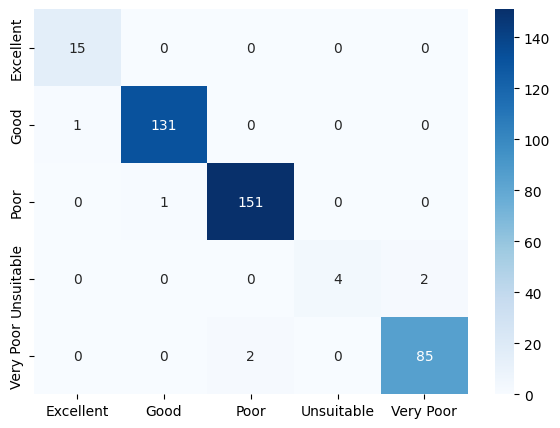

In [ ]:
# Step 11: Hybrid Ensemble (XGBoost + LSTM)
# ================================================
# Stack predicted probabilities
X_meta_train = np.hstack([xgb_model.predict_proba(X_tab_train), lstm_model.predict(X_lstm_train)])
X_meta_test = np.hstack([xgb_pred_proba, lstm_pred_proba])

# Handle any NaNs
X_meta_train = np.nan_to_num(X_meta_train)
X_meta_test = np.nan_to_num(X_meta_test)

# Train meta-model
meta_model = LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)
meta_model.fit(X_meta_train, y_train)
meta_pred = meta_model.predict(X_meta_test)

# Accuracy & Classification Report
meta_acc = accuracy_score(y_test, meta_pred)
print("Hybrid Ensemble Accuracy:", round(meta_acc*100,2), "%")
print(classification_report(y_test, meta_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, meta_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
n_splits = 5  # 5-fold CV
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
acc_scores = []
fold = 1
for train_index, test_index in skf.split(X_tab_scaled, y_encoded):
    print(f"\n=== Fold {fold} ===")

    # Split tabular and LSTM inputs
    X_tab_train, X_tab_test = X_tab_scaled[train_index], X_tab_scaled[test_index]
    X_lstm_train, X_lstm_test = X_lstm[train_index], X_lstm[test_index]
    y_train, y_test_fold = y_encoded[train_index], y_encoded[test_index]

    # --- Train XGBoost ---
    import xgboost as xgb
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_tab_train, y_train)
    xgb_pred_proba = xgb_model.predict_proba(X_tab_test)

    # --- Train LSTM ---
    from tensorflow.keras import models, layers, callbacks
    n_timesteps = X_lstm_train.shape[1]
    n_features = X_lstm_train.shape[2]
    n_classes = len(np.unique(y_encoded))

    lstm_model = models.Sequential([
        layers.Input(shape=(n_timesteps, n_features)),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])

    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    lstm_model.fit(
        X_lstm_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    lstm_pred_proba = lstm_model.predict(X_lstm_test)

    # --- Stack predictions ---
    # Concatenate XGBoost and LSTM probabilities as meta-features
    X_meta_train = np.hstack([
        xgb_model.predict_proba(X_tab_train),
        lstm_model.predict(X_lstm_train)
    ])
    X_meta_test = np.hstack([xgb_pred_proba, lstm_pred_proba])

    # Handle potential NaN values in meta-features
    X_meta_train = np.nan_to_num(X_meta_train, nan=0.0)
    X_meta_test  = np.nan_to_num(X_meta_test, nan=0.0)


    # --- Meta-model: Logistic Regression ---
    from sklearn.linear_model import LogisticRegression
    meta_model = LogisticRegression(max_iter=200, multi_class='ovr')
    meta_model.fit(X_meta_train, y_train)

    meta_pred = meta_model.predict(X_meta_test)

    # --- Metrics ---
    acc = accuracy_score(y_test_fold, meta_pred)
    print(f"Fold {fold} Accuracy: {round(acc*100, 2)}%")
    acc_scores.append(acc)
    fold += 1

print("\n✅ Cross-Validation Results")
print("Accuracies per fold:", [round(a*100, 2) for a in acc_scores])
print("Mean Accuracy:", round(np.mean(acc_scores)*100, 2), "%")
print("Std Deviation:", round(np.std(acc_scores)*100, 2), "%")


=== Fold 1 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 Accuracy: 97.7%

=== Fold 2 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 Accuracy: 97.45%

=== Fold 3 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 Accuracy: 98.21%

=== Fold 4 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 Accuracy: 98.72%

=== Fold 5 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5 Accuracy: 98.47%

✅ Cross-Validation Results
Accuracies per fold: [97.7, 97.45, 98.21, 98.72, 98.47]
Mean Accuracy: 98.11 %
Std Deviation: 0.47 %


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from tensorflow.keras import models, layers, callbacks

# --- 10-fold Stratified CV setup ---
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

acc_scores = []
fold = 1

for train_index, test_index in skf.split(X_tab_scaled, y_encoded):
    print(f"\n=== Fold {fold} / {n_splits} ===")

    # Split data
    X_tab_train, X_tab_test = X_tab_scaled[train_index], X_tab_scaled[test_index]
    X_lstm_train, X_lstm_test = X_lstm[train_index], X_lstm[test_index]
    y_train, y_test_fold = y_encoded[train_index], y_encoded[test_index]

    # --- Train XGBoost ---
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_tab_train, y_train)
    xgb_pred_proba = xgb_model.predict_proba(X_tab_test)

    # --- Train LSTM ---
    n_timesteps = X_lstm_train.shape[1]
    n_features = X_lstm_train.shape[2]
    n_classes = len(np.unique(y_encoded))

    lstm_model = models.Sequential([
        layers.Input(shape=(n_timesteps, n_features)),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])

    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    lstm_model.fit(
        X_lstm_train, y_train,
        validation_split=0.1,
        epochs=25,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    lstm_pred_proba = lstm_model.predict(X_lstm_test, verbose=0)

    # --- Stack outputs ---
    X_meta_train = np.hstack([
        xgb_model.predict_proba(X_tab_train),
        lstm_model.predict(X_lstm_train, verbose=0)
    ])
    X_meta_test = np.hstack([xgb_pred_proba, lstm_pred_proba])

    # Replace NaN with zeros (to prevent ValueError)
    X_meta_train = np.nan_to_num(X_meta_train)
    X_meta_test = np.nan_to_num(X_meta_test)

    # --- Meta-model: Logistic Regression ---
    meta_model = LogisticRegression(max_iter=200, multi_class='ovr')
    meta_model.fit(X_meta_train, y_train)
    meta_pred = meta_model.predict(X_meta_test)

    # --- Metrics ---
    acc = accuracy_score(y_test_fold, meta_pred)
    print(f"Fold {fold} Accuracy: {round(acc*100, 2)}%")
    acc_scores.append(acc)

    # Optional: classification report
    try:
        print(classification_report(y_test_fold, meta_pred, target_names=le.classes_, zero_division=0))
    except Exception:
        print("⚠ Skipping detailed report (class mismatch in this fold).")

    fold += 1

# --- Summary ---
print("\n✅ 10-Fold Cross-Validation Results:")
print("Accuracies per fold:", [round(a*100, 2) for a in acc_scores])
print("Mean Accuracy:", round(np.mean(acc_scores)*100, 2), "%")
print("Std Deviation:", round(np.std(acc_scores)*100, 2), "%")



=== Fold 1 / 10 ===
Fold 1 Accuracy: 97.45%
              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00         7
        Good       1.00      0.97      0.98        66
        Poor       0.96      0.99      0.97        77
  Unsuitable       0.75      1.00      0.86         3
   Very Poor       0.98      0.95      0.96        43

    accuracy                           0.97       196
   macro avg       0.94      0.98      0.96       196
weighted avg       0.98      0.97      0.97       196


=== Fold 2 / 10 ===
Fold 2 Accuracy: 98.47%
              precision    recall  f1-score   support

   Excellent       0.88      1.00      0.93         7
        Good       0.98      0.98      0.98        66
        Poor       1.00      0.99      0.99        76
  Unsuitable       1.00      0.67      0.80         3
   Very Poor       0.98      1.00      0.99        44

    accuracy                           0.98       196
   macro avg       0.97      0.93      0.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from tensorflow.keras import models, layers, callbacks

# --- 100-fold Stratified CV setup ---
n_splits = 100
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

acc_scores = []
mse_scores = []
mae_scores = []
rmse_scores = []
fold = 1

for train_index, test_index in skf.split(X_tab_scaled, y_encoded):
    print(f"\n=== Fold {fold} / {n_splits} ===")

    # Split data
    X_tab_train, X_tab_test = X_tab_scaled[train_index], X_tab_scaled[test_index]
    X_lstm_train, X_lstm_test = X_lstm[train_index], X_lstm[test_index]
    y_train, y_test_fold = y_encoded[train_index], y_encoded[test_index]

    # Skip folds with too few samples or missing classes
    if len(np.unique(y_test_fold)) < 2:
        print("⚠ Skipping fold due to insufficient class diversity.")
        fold += 1
        continue

    # --- XGBoost model ---
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_tab_train, y_train)
    xgb_pred_proba = xgb_model.predict_proba(X_tab_test)

    # --- LSTM model ---
    n_timesteps = X_lstm_train.shape[1]
    n_features = X_lstm_train.shape[2]
    n_classes = len(np.unique(y_encoded))

    lstm_model = models.Sequential([
        layers.Input(shape=(n_timesteps, n_features)),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])

    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    lstm_model.fit(
        X_lstm_train, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    lstm_pred_proba = lstm_model.predict(X_lstm_test, verbose=0)

    # --- Stack model outputs ---
    X_meta_train = np.hstack([
        xgb_model.predict_proba(X_tab_train),
        lstm_model.predict(X_lstm_train, verbose=0)
    ])
    X_meta_test = np.hstack([xgb_pred_proba, lstm_pred_proba])

    # Replace NaN/inf with zeros
    X_meta_train = np.nan_to_num(X_meta_train)
    X_meta_test = np.nan_to_num(X_meta_test)

    # --- Meta learner ---
    meta_model = LogisticRegression(max_iter=200, multi_class='ovr')
    meta_model.fit(X_meta_train, y_train)
    meta_pred = meta_model.predict(X_meta_test)

    # --- Metrics ---
    acc = accuracy_score(y_test_fold, meta_pred)
    mse = mean_squared_error(y_test_fold, meta_pred)
    mae = mean_absolute_error(y_test_fold, meta_pred)
    rmse = np.sqrt(mse)

    print(f"Fold {fold} Accuracy: {round(acc*100, 2)}%")
    print(f"Fold {fold} MSE: {round(mse, 4)}, MAE: {round(mae, 4)}, RMSE: {round(rmse, 4)}")

    acc_scores.append(acc)
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

    try:
        print(classification_report(y_test_fold, meta_pred, target_names=le.classes_, zero_division=0))
    except Exception:
        print("⚠ Skipping detailed report (class mismatch in this fold).")

    fold += 1

# --- Summary ---
print("\n✅ 100-Fold Cross-Validation Results:")
print("Accuracies per fold:", [round(a*100, 2) for a in acc_scores])
print("Mean Accuracy:", round(np.mean(acc_scores)*100, 2), "%")
print("Std Deviation:", round(np.std(acc_scores)*100, 2), "%")

print("\n✅ 100-Fold Cross-Validation Regression Metrics (Mean):")
print("Mean MSE:", round(np.mean(mse_scores), 4))
print("Mean MAE:", round(np.mean(mae_scores), 4))
print("Mean RMSE:", round(np.mean(rmse_scores), 4))


=== Fold 1 / 100 ===
Fold 1 Accuracy: 100.0%
Fold 1 MSE: 0.0, MAE: 0.0, RMSE: 0.0
⚠ Skipping detailed report (class mismatch in this fold).

=== Fold 2 / 100 ===
Fold 2 Accuracy: 100.0%
Fold 2 MSE: 0.0, MAE: 0.0, RMSE: 0.0
⚠ Skipping detailed report (class mismatch in this fold).

=== Fold 3 / 100 ===
Fold 3 Accuracy: 100.0%
Fold 3 MSE: 0.0, MAE: 0.0, RMSE: 0.0
⚠ Skipping detailed report (class mismatch in this fold).

=== Fold 4 / 100 ===
Fold 4 Accuracy: 100.0%
Fold 4 MSE: 0.0, MAE: 0.0, RMSE: 0.0
⚠ Skipping detailed report (class mismatch in this fold).

=== Fold 5 / 100 ===
Fold 5 Accuracy: 95.0%
Fold 5 MSE: 0.2, MAE: 0.1, RMSE: 0.4472
⚠ Skipping detailed report (class mismatch in this fold).

=== Fold 6 / 100 ===
Fold 6 Accuracy: 100.0%
Fold 6 MSE: 0.0, MAE: 0.0, RMSE: 0.0
⚠ Skipping detailed report (class mismatch in this fold).

=== Fold 7 / 100 ===
Fold 7 Accuracy: 100.0%
Fold 7 MSE: 0.0, MAE: 0.0, RMSE: 0.0
⚠ Skipping detailed report (class mismatch in this fold).

=== Fold 8

In [ ]:
acc_scores = []
mse_scores = []
mae_scores = []
rmse_scores = []

# inside the loop
acc_scores.append(acc)
mse_scores.append(mse)
mae_scores.append(mae)
rmse_scores.append(rmse)

# after the loop
print("\n✅ 100-Fold Cross-Validation Summary:")
print("Mean Accuracy:", round(np.mean(acc_scores)*100, 2), "%")
print("Mean MSE:", round(np.mean(mse_scores), 4))
print("Mean MAE:", round(np.mean(mae_scores), 4))
print("Mean RMSE:", round(np.mean(rmse_scores), 4))




✅ 100-Fold Cross-Validation Summary:
Mean Accuracy: 100.0 %
Mean MSE: 0.0
Mean MAE: 0.0
Mean RMSE: 0.0


In [ ]:
import os
import joblib
from tensorflow.keras.models import load_model

# --- Create directory if not exists ---
save_dir = "/content/drive/MyDrive/models"
os.makedirs(save_dir, exist_ok=True)

# --- Save LSTM Model ---
try:
    lstm_model.save(f"{save_dir}/lstm_water_quality.h5")
    print("✅ LSTM model saved.")
except NameError:
    print("⚠️ LSTM model not found. Train it before saving.")

# --- Save XGBoost Model ---
try:
    xgb_model.save_model(f"{save_dir}/xgboost_water_quality.json")
    print("✅ XGBoost model saved.")
except NameError:
    print("⚠️ XGBoost model not found. Train it before saving.")

# --- Save Meta-Model (Logistic Regression) ---
try:
    joblib.dump(meta_model, f"{save_dir}/meta_logistic.pkl")
    print("✅ Meta-model saved.")
except NameError:
    print("⚠️ Meta-model not found. Train it before saving.")

# --- Save LabelEncoder and Scaler ---
try:
    joblib.dump(le, f"{save_dir}/label_encoder.pkl")
    joblib.dump(scaler_tab, f"{save_dir}/scaler.pkl")
    print("✅ LabelEncoder and Scaler saved.")
except NameError:
    print("⚠️ LabelEncoder or Scaler not found. Please run training section first.")

print("\n🎯 Model saving process completed.")


✅ LSTM model saved.
✅ XGBoost model saved.
✅ Meta-model saved.
✅ LabelEncoder and Scaler saved.

🎯 Model saving process completed.
